## HuBMAP Inference

### version1,2: legacy version

### version3: [my public train code](https://www.kaggle.com/code/itsuki9180/hubmap-train)

### version4: my code with a few changes. and using dilation. Please read [this discussion on dilation](https://www.kaggle.com/competitions/hubmap-hacking-the-human-vasculature/discussion/416901).

In [1]:
import os, glob
import sys
import json
from PIL import Image
from collections import Counter

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import tifffile as tiff
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import cv2
from skimage.morphology import binary_dilation

import pandas as pd

from sklearn.model_selection import KFold

sys.path.append("/kaggle/input/detection-wheel")

In [2]:
# Install pycocotools package
import os
!mkdir /kaggle/working/packages
!cp -r /kaggle/input/pycocotools/* /kaggle/working/packages
os.chdir("/kaggle/working/packages/pycocotools-2.0.6/")
!python setup.py install -q
!pip install . --no-index --find-links /kaggle/working/packages/ -q
os.chdir("/kaggle/working")

running install
/opt/conda/lib/python3.10/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/setuptools/command/easy_install.py:156: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
running bdist_egg
running egg_info
writing pycocotools.egg-info/PKG-INFO
writing dependency_links to pycocotools.egg-info/dependency_links.txt
writing requirements to pycocotools.egg-info/requires.txt
writing top-level names to pycocotools.egg-info/top_level.txt
reading manifest file 'pycocotools.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'pycocotools.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib.linux-x86_64-3.10
cre

In [3]:
import base64
import numpy as np
from pycocotools import _mask as coco_mask
import typing as t
import zlib

def encode_binary_mask(mask: np.ndarray) -> t.Text:
  """Converts a binary mask into OID challenge encoding ascii text."""

  # check input mask --
  if mask.dtype != np.bool:
    raise ValueError(
        "encode_binary_mask expects a binary mask, received dtype == %s" %
        mask.dtype)

  mask = np.squeeze(mask)
  if len(mask.shape) != 2:
    raise ValueError(
        "encode_binary_mask expects a 2d mask, received shape == %s" %
        mask.shape)

  # convert input mask to expected COCO API input --
  mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
  mask_to_encode = mask_to_encode.astype(np.uint8)
  mask_to_encode = np.asfortranarray(mask_to_encode)

  # RLE encode mask --
  encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]

  # compress and base64 encoding --
  binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
  base64_str = base64.b64encode(binary_str)
  return base64_str

In [4]:
import os
import numpy as np
import torch
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, imgs, transforms):
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = imgs
        self.name_indices = [os.path.splitext(os.path.basename(i))[0] for i in imgs]

    def __getitem__(self, idx):
        # load images and masks
        img_path = self.imgs[idx]
        name = self.name_indices[idx]
        array = tiff.imread(img_path)
        img = Image.fromarray(array)
        
        img, _ = self.transforms(img, img)

        return img, name

    def __len__(self):
        return len(self.imgs)

In [5]:
import torchvision
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights=None, weights_backbone=None)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [6]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    return T.Compose(transforms)

In [7]:
from engine import train_one_epoch, evaluate
import utils

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [9]:
model = get_model_instance_segmentation(num_classes=2)
model.to(device)
model.load_state_dict(torch.load('/kaggle/input/hubmap-well-tuned/well_tuned_weight.pth'))
model.eval()
print()

In [10]:
all_imgs = glob.glob('/kaggle/input/hubmap-hacking-the-human-vasculature/test/*.tif')
dataset_test = PennFudanDataset(all_imgs, get_transform(train=False))
test_dl = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=os.cpu_count(), pin_memory=True)

In [11]:
ids = []
heights = []
widths = []
prediction_strings = []

In [12]:
sample = None
with torch.no_grad():
    for img, idx in test_dl:
        img = img.to(device)
        pred = model(img)
        if sample is None: sample=pred
        pred_string = ''
        for m in range(len(pred[0]['masks'])):
            mask = pred[0]['masks'][m].detach().permute(1,2,0).cpu().numpy()
            mask = np.where(mask>0.5, 1, 0).astype(np.bool)
            mask = binary_dilation(mask)
            
            score = pred[0]['scores'][m].detach().cpu().numpy()
            encoded = encode_binary_mask(mask)
            if m==0:
                pred_string += f"0 {score} {encoded.decode('utf-8')}"

            else:
                pred_string += f" 0 {score} {encoded.decode('utf-8')}"
        b, c, h, w = img.shape
        ids.append(idx[0])
        heights.append(h)
        widths.append(w)
        prediction_strings.append(pred_string)

/tmp/ipykernel_28/1326948893.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.where(mask>0.5, 1, 0).astype(np.bool)
/tmp/ipykernel_28/2079321387.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if mask.dtype != np.bool:


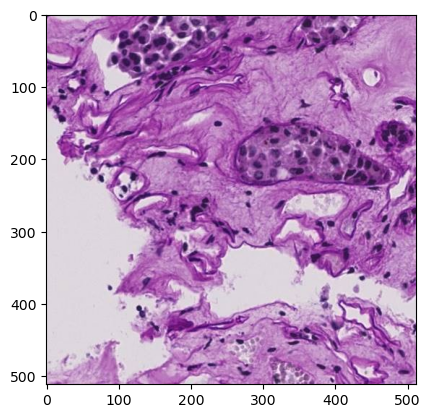

In [13]:
array = tiff.imread('/kaggle/input/hubmap-hacking-the-human-vasculature/test/72e40acccadf.tif')
plt.imshow(array)
plt.show()

0.97584677


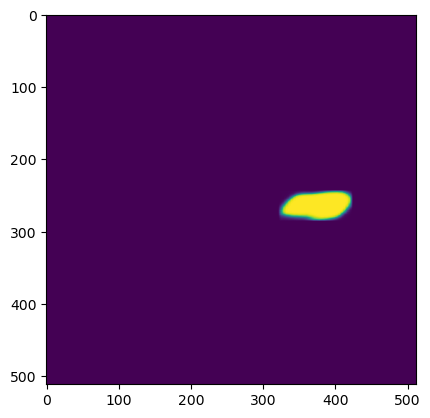

0.9484322


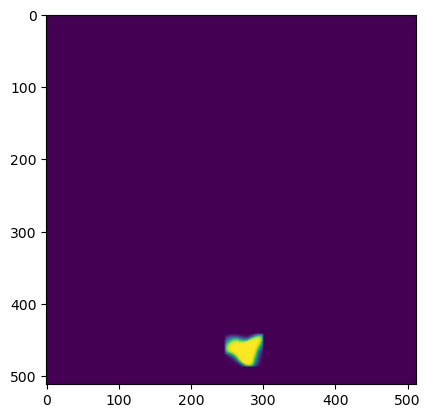

0.9465909


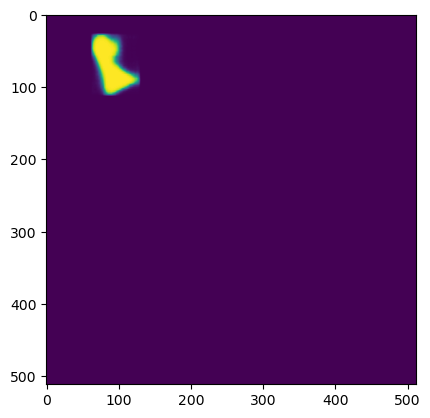

0.94556254


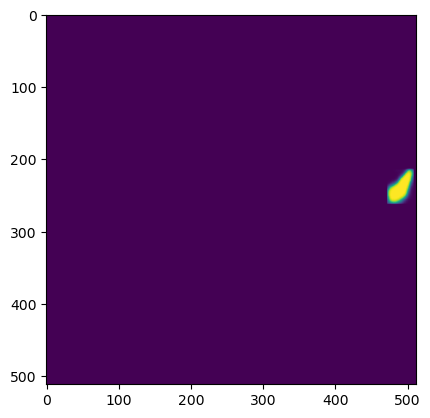

0.9396188


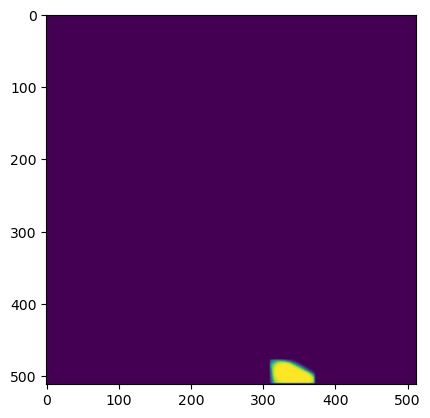

0.9229616


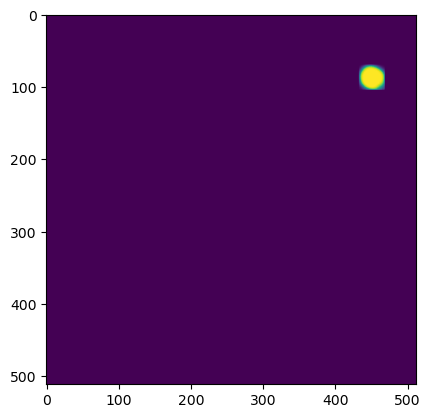

0.9159438


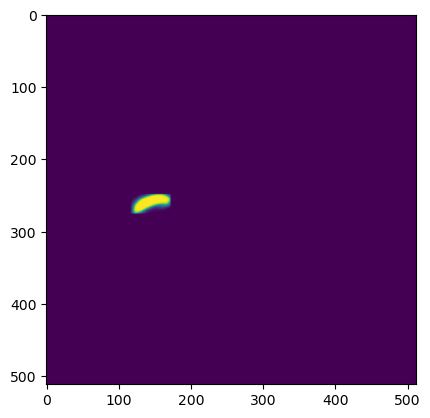

0.8924566


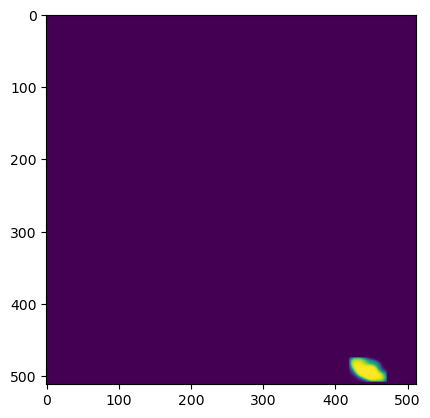

0.8874912


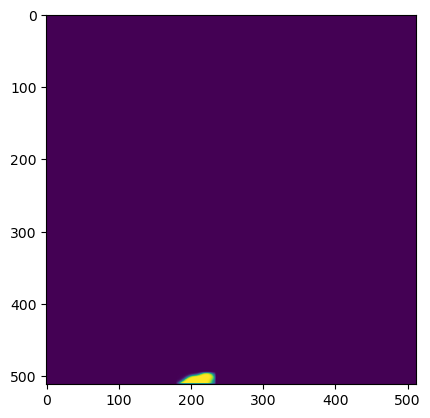

0.88016355


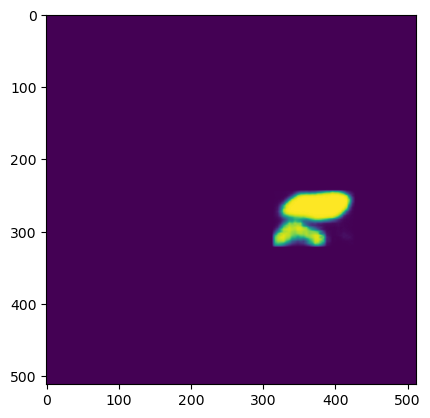

0.77933896


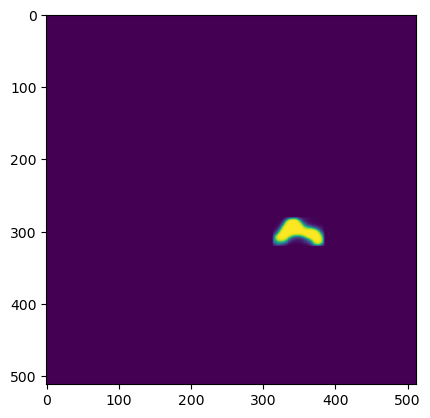

0.776923


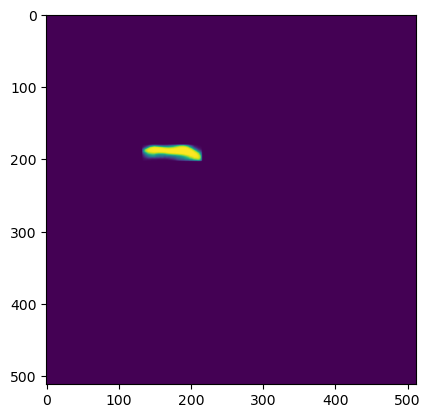

0.73804337


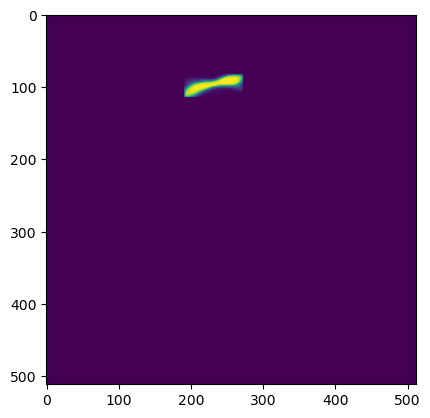

0.70671487


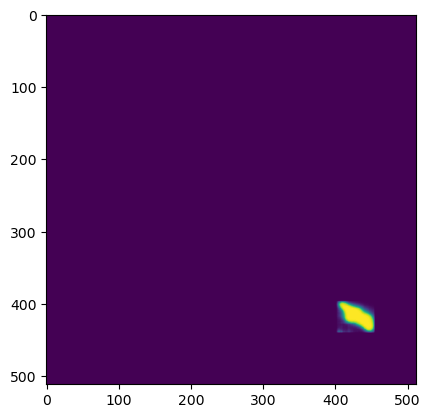

0.705474


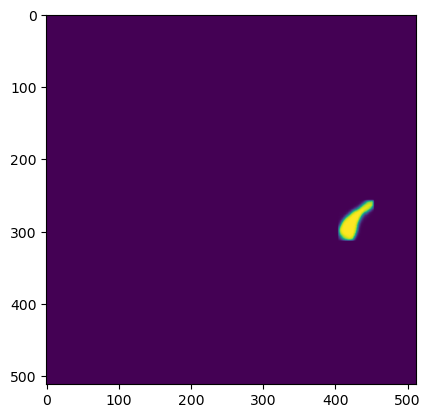

0.6552496


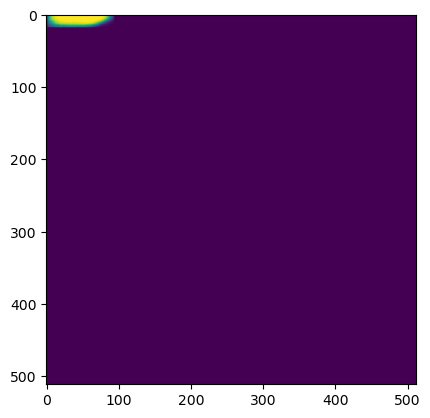

0.6239108


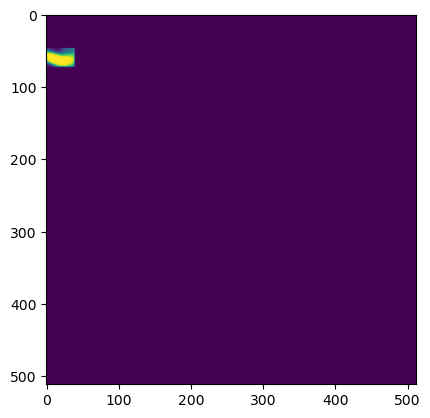

0.5252256


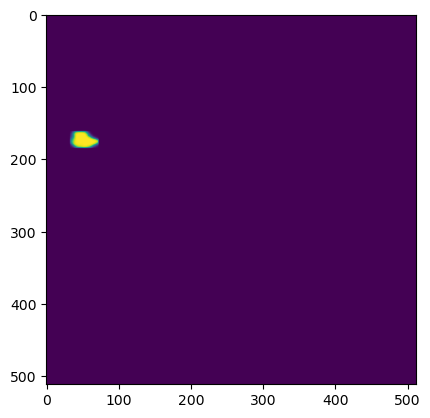

0.4783288


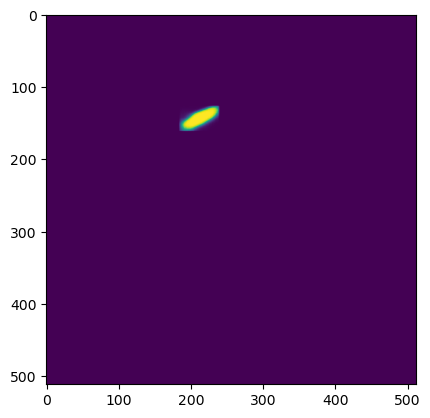

0.45950246


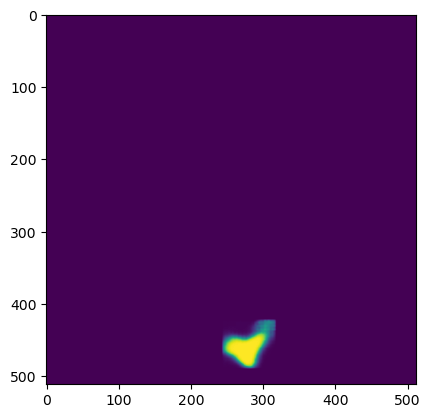

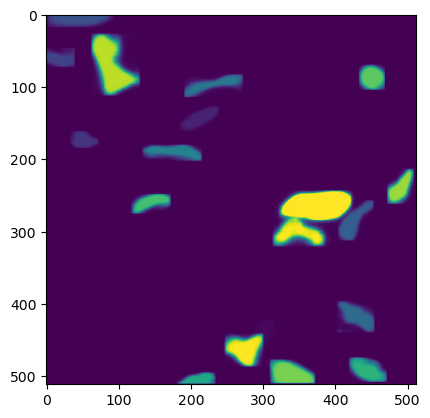

In [14]:
if len(all_imgs)==1:
    top20 = [sample[0]['masks'][i].cpu().numpy().reshape(512, 512) for i in range(min(20,len(sample[0]['masks'])))]
    
    pred_img = np.zeros((512,512), dtype=np.float32)
    for i, j in enumerate(top20):
        pred_img += j * (1 - 1/len(top20)*i)
        pred_img = np.clip(pred_img, 0, 1)
        print(sample[0]['scores'][i].cpu().numpy())
        plt.imshow(j)
        plt.show()
        
    plt.imshow(pred_img)
    plt.show()

In [15]:
submission = pd.DataFrame()
submission['id'] = ids
submission['height'] = heights
submission['width'] = widths
submission['prediction_string'] = prediction_strings
submission = submission.set_index('id')
submission.to_csv("submission.csv")
submission.head()

,height,width,prediction_string
id,,,
72e40acccadf,512,512,0 0.9758467674255371 eNqLjwgyNTQyyLA38zX2NfYz8...
